In [ ]:
import numpy as np
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [ ]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


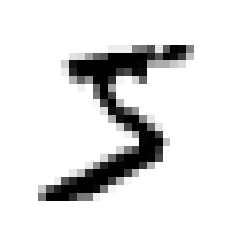

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [ ]:
y[0]

'5'

In [ ]:
y = y.astype(np.uint8) # y를 정수로 변환

In [ ]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 이진 분류기 훈련

In [ ]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

array([ True])

## 성능 측정

### 교차검증 (cross_val_score)
#### 정확도를 분류기의 성능 측정 지표로 선호하지 않는 이유, 특히 불균형한 데이터 셋일 때

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.95035
0.96035
0.9604


In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train,y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [ ]:
from sklearn.base import BaseEstimator
# 절대 5가 아님만 결과를 내는 모델
class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X),1), dtype=bool)

In [ ]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

### 오차 행렬

In [ ]:
from sklearn.model_selection import cross_val_predict
# k-겹 교차 검증을 수행하지만 평가 점수를 반환하지 않고 각 테스트 폴드에서 얻은 예측을 반환

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

맨 왼쪽부터 차례대로 true Negative, false positive, false Negative, true Positive

* 정밀도 : TP / (TP + FP)
* 재현율 : TP / (TP + FN)

### 정밀도와 재현율

In [ ]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.8370879772350012
0.6511713705958311


### F1 score ( 정밀도와 재현율의 조화평균 )

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

### 정밀도/재현율 트레이드오프
둘 중 하나가 올라가면 다른 하나는 내려간다.

predict() -> decision_function() 으로 각 샘플의 점수를 얻을 수 있다.

In [ ]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

# 임계값 높이면
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[2164.22030239]
[ True]
[False]


임계값을 높였더니 재현율이 내려가는 것을 볼 수 있다.

#### 적절한 임곗값 정하기

In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

precision_recall_curve를 이용하여 가능한 모든 임곗값에 대해 정밀도와 재현율 계산

In [ ]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

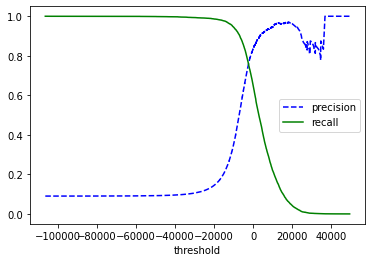

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1],"b--",label="precision")
  plt.plot(thresholds, recalls[:-1],"g-",label="recall")
  plt.legend()
  plt.xlabel("threshold")
  plt.show()
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

재현율에 대한 정밀도 곡선을 그려 좋은 정밀도/재현율 트레이드오프를 선택하는 방법

-> 정밀도가 급격하게 줄어드는 하강점 직전이 주로 좋다.

In [ ]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]

In [ ]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [ ]:
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9000345901072293
0.4799852425751706


### ROC 곡선

* 거짓 양성 비율(FPR)에 대한 진짜 양성 비율(TPR)의 곡선
* 민감도(재현율)에 대한 1 - 특이도 그래프

FPR : 양성으로 잘못 분류된 음성 샘플의 비율, 1 - TNR

TNR : 특이도

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

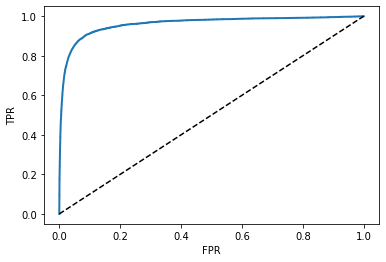

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0,1],[0,1],'k--')
  plt.xlabel('FPR')
  plt.ylabel('TPR')
  
plot_roc_curve(fpr,tpr)
plt.show()

AUC(곡선 아래의 면적)가 1이면 완벽한 분류기, 0.5이면 완전한 랜덤 분류기

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

#### RandomForestCalssifier와 ROC 비교
* RandomForestCalssifier에는 decision_function이 없어서 predict_proba() 사용

predict_proba는 샘플이 행, 클래스가 열

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")


In [ ]:
y_scores_forest = y_probas_forest[:,1] # 양성 클래스에 대한 확률을 점수로 사용합니다.
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

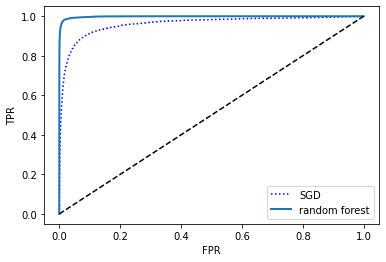

In [ ]:
plt.plot(fpr,tpr,"b:",label="SGD")
plot_roc_curve(fpr_forest,tpr_forest,"random forest")
plt.legend(loc="lower right")
plt.show()

In [ ]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

-> 랜덤포레스트가 SGD보다 좋다

### 다중 분류

#### OvR( One versus the rest ) 전략

이진 분류기 n개를 이용하여 클래스가 n개인 이미지 분류 시스템 만드는 것. 이때 각 분류기의 결정 점수 중에서 가장 높은 것을 클래스로 선택

#### OvO( One versus one ) 전략

0과 1 구별, 0과 2 구별, 1과 2 구별 등 각 숫자의 조합마다 이진 분류기 훈련시키는 것

N개의 클래스 -> N * (N-1) / 2개의 분류기 필요

In [ ]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train,y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

서포트 벡터 머신은 이진분류기이기 때문에 사이킷런 내부에서 OvO전략을 사용해 10개의 분류기를 훈련시키고 각각의 결정점수를 얻어 점수가 가장 높은 클래스를 선택했을 것

In [ ]:
some_digit_scores = svm_clf.decision_function([some_digit])

In [ ]:
print(np.argmax(some_digit_scores))
print(svm_clf.classes_)
print(svm_clf.classes_[5])

5
[0 1 2 3 4 5 6 7 8 9]
5


OvO, OvR을 사용하도록 강제

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [ ]:
len(ovr_clf.estimators_)

10

In [ ]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [ ]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv = 3,scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

In [ ]:
### 에러 분석

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

오차 행렬을 맷플롬립의 matshow()로 표현하기

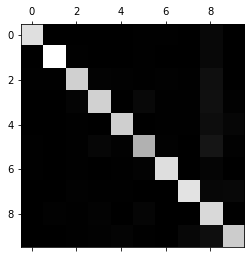

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

에러의 비율 비교

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

SyntaxError: ignored

### 다중 레이블 분류

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train %2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

In [ ]:
knn_clf.predict([some_digit])

모든 레이블에 대한 F1 점수의 평균으로 다중 레이블 분류기 평가하기

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

위의 코드는 모든 레이블의 가중치가 같다고 가정한 것( 데이터의 비율이 비슷하다)

만약 아니라면 레이블에 클래스의 지지도(타깃 레이블에 속한 샘플 수)를 가중치로 두는 방법도 있음 -> average="weighted"

### 다중 출력 분류

이미지 잡음 제거 시스템

In [ ]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0,100,(len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
knn_clf.fit(X_train_ mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

### 연습문제